# Baseline BERT Model

In [1]:
# Append the directory containing the src folder to sys.path
import sys

sys.path.append('/Users/lars/Documents/Uni/Masterarbeit/Online_Process_Concept_Drift')

In [2]:
%pip list

Package                       Version
----------------------------- --------------
absl-py                       1.4.0
aioboto3                      12.4.0
aiobotocore                   2.12.3
aiohttp                       3.9.5
aioitertools                  0.11.0
aiosignal                     1.3.1
annotated-types               0.6.0
anyio                         4.3.0
appnope                       0.1.4
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow                         1.3.0
asttokens                     2.4.1
astunparse                    1.6.3
async-lru                     2.0.4
async-timeout                 4.0.3
attrs                         23.2.0
Babel                         2.15.0
beautifulsoup4                4.12.3
bleach                        6.1.0
boto3                         1.34.69
botocore                      1.34.69
cachetools                    5.3.3
certifi                       2024.2.2
cffi                          1.16.0
c

In [11]:
#%pip install /Users/lars/Downloads/tensorflow_text-2.15.0-cp310-cp310-macosx_11_0_arm64.whl

Processing /Users/lars/Downloads/tensorflow_text-2.15.0-cp310-cp310-macosx_11_0_arm64.whl
  Using cached tensorflow_macos-2.15.1-cp310-cp310-macosx_12_0_arm64.whl (2.2 kB)
  Attempting uninstall: tensorflow-text
    Found existing installation: tensorflow-text 2.16.1
    Uninstalling tensorflow-text-2.16.1:
      Successfully uninstalled tensorflow-text-2.16.1
You should consider upgrading via the '/Users/lars/Documents/test/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
#%pip install -U "tf-models-official==2.15.*"

  Using cached tf_models_official-2.15.0-py2.py3-none-any.whl (2.7 MB)
  Using cached sacrebleu-2.4.2-py3-none-any.whl (106 kB)
  Using cached pycocotools-2.0.7-cp310-cp310-macosx_10_9_universal2.whl (169 kB)
  Using cached tensorflow_datasets-4.9.4-py3-none-any.whl (5.1 MB)
  Using cached google_api_python_client-2.129.0-py2.py3-none-any.whl (11.6 MB)
  Using cached kaggle-1.6.12-py3-none-any.whl
  Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl (242 kB)
  Using cached sentencepiece-0.2.0-cp310-cp310-macosx_11_0_arm64.whl (1.2 MB)
  Using cached gin_config-0.5.0-py3-none-any.whl (61 kB)
  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl (35.4 MB)
  Using cached seqeval-1.2.2-py3-none-any.whl
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Using cached immutabledict-4.2.0-py3-none-any.whl (4.7 kB)
  Using cached oauth2client-4.1.3-py2.py3-none-any.whl (98 kB)
  Using cached Cython-3.0.10-py2.py3-none-any.whl (1.2 MB)
  Using 

In [2]:
#Path variables for datasets
directory = "/Users/lars/Documents/Uni/Masterarbeit/Online_Process_Concept_Drift"
path_raw = "/data/raw/"
path_interim = "/data/interim/"
path_processed = "/data/processed/"

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import tensorflow_text as text
import tensorflow_hub as hub
from src.data.data_manager import data_loader, save_event_log, delete_dataframes
import numpy as np


TensorFlow version: 2.15.1


In [4]:
print("TensorFlow version:", text.__version__)

TensorFlow version: 2.15.0


In [5]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score

In [6]:
train_tensor = data_loader(directory, path_interim, "Train")
val_tensor = data_loader(directory, path_interim, "Val")
test_tensor = data_loader(directory, path_interim, "Test")

In [7]:
val_tensor

,Prefix_Trace,Next_Activity
0,assign-seriousness,take-in-charge-ticket
1,assign-seriousness take-in-charge-ticket,wait
2,assign-seriousness take-in-charge-ticket wait,resolve-ticket
3,assign-seriousness take-in-charge-ticket wait ...,closed
4,assign-seriousness take-in-charge-ticket wait ...,end
...,...,...
2800,insert-ticket,assign-seriousness
2801,insert-ticket assign-seriousness,take-in-charge-ticket
2802,insert-ticket assign-seriousness take-in-charg...,resolve-ticket
2803,insert-ticket assign-seriousness take-in-charg...,closed


In [8]:
class BERTPreprocessor:
    def __init__(self, max_length=512):
        self.preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
        self.max_length = max_length
        self.activity_to_label = {}
        self.label_to_activity = {}
        self.next_label_index = 0

    def fit_activity_labels(self, df):
        activities = df['Next_Activity'].unique()
        self.activity_to_label = {activity: idx for idx, activity in enumerate(activities)}
        self.label_to_activity = {idx: activity for activity, idx in self.activity_to_label.items()}
        self.next_label_index = len(activities)

    def preprocess(self, df):
        text_inputs = df['Prefix_Trace'].tolist()
        preprocessed_text = self.preprocessor(text_inputs)

        input_word_ids = tf.keras.preprocessing.sequence.pad_sequences(preprocessed_text['input_word_ids'], maxlen=self.max_length, padding='post', truncating='post')
        input_mask = tf.keras.preprocessing.sequence.pad_sequences(preprocessed_text['input_mask'], maxlen=self.max_length, padding='post', truncating='post')
        input_type_ids = tf.keras.preprocessing.sequence.pad_sequences(preprocessed_text['input_type_ids'], maxlen=self.max_length, padding='post', truncating='post')

        labels = []
        for next_activity in df['Next_Activity']:
            if next_activity not in self.activity_to_label:
                self.activity_to_label[next_activity] = self.next_label_index
                self.label_to_activity[self.next_label_index] = next_activity
                self.next_label_index += 1
            labels.append(self.activity_to_label[next_activity])

        input_word_ids = tf.convert_to_tensor(input_word_ids)
        input_mask = tf.convert_to_tensor(input_mask)
        input_type_ids = tf.convert_to_tensor(input_type_ids)
        labels = tf.convert_to_tensor(labels)

        preprocessed_text = {
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids,
            'labels': labels
        }

        return preprocessed_text

In [9]:
preprocessor = BERTPreprocessor(max_length=512)
preprocessor.fit_activity_labels(train_tensor)  # Fit activity labels on the training set

bert_input_train = preprocessor.preprocess(train_tensor)
bert_input_val = preprocessor.preprocess(val_tensor)
bert_input_test = preprocessor.preprocess(test_tensor)


print(bert_input_train)

{'input_word_ids': <tf.Tensor: shape=(13175, 512), dtype=int32, numpy=
array([[  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       ...,
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0]], dtype=int32)>, 'input_mask': <tf.Tensor: shape=(13175, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(13175, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtyp

In [10]:
class BERTModelBuilder:
    def __init__(self, preprocessor_url, encoder_url, num_classes, max_length=512):
        self.preprocessor_url = preprocessor_url
        self.encoder_url = encoder_url
        self.num_classes = num_classes
        self.max_length = max_length

    def create_model(self):
        '''
        Creates a BERT model for predicting the next activity in a sequence of activities.

        Input:
            - preprocessor_url: str - URL of the BERT preprocessor from TensorFlow Hub.
            - encoder_url: str - URL of the BERT encoder from TensorFlow Hub.
            - num_classes: int - number of unique classes (activities) for classification.
            - max_length (optional): int - maximum length for tokenized sequences. Default is 512.

        Output:
            - model: tf.keras.Model - a compiled Keras model ready for training.
        '''

        # Load the BERT preprocessor and encoder from TensorFlow Hub
        preprocessor = hub.KerasLayer(self.preprocessor_url, name='preprocessing')
        encoder = hub.KerasLayer(self.encoder_url, trainable=True, name='BERT_encoder')

        # Define the model inputs
        input_word_ids = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='input_type_ids')

        # Encode the inputs with BERT
        encoder_inputs = {
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
        }
        encoder_outputs = encoder(encoder_inputs)
        pooled_output = encoder_outputs['pooled_output']  # [batch_size, 768]

        # Add a dropout layer for regularization
        dropout = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

        # Add a dense layer for classification
        output = tf.keras.layers.Dense(self.num_classes, activation='softmax', name='output')(dropout)

        # Create the model
        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)

        # Compile the model with AdamW optimizer
        model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
                      run_eagerly=True)  # Run eagerly to debug issues

        return model

class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_data = self.validation_data
        val_pred = self.model.predict(val_data[0])
        val_pred = tf.argmax(val_pred, axis=1)
        val_true = val_data[1]

        f1 = f1_score(val_true, val_pred, average='weighted')
        precision = precision_score(val_true, val_pred, average='weighted')
        recall = recall_score(val_true, val_pred, average='weighted')

        print(f' — val_f1: {f1:.4f} — val_precision: {precision:.4f} — val_recall: {recall:.4f}')


In [11]:
# URLs for the pre-trained BERT model and the preprocessor
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

num_classes = len(preprocessor.activity_to_label)

# Initialize and create the model
model_builder = BERTModelBuilder(preprocessor_url=tfhub_handle_preprocess, 
                                 encoder_url=tfhub_handle_encoder, 
                                 num_classes=num_classes)

model = model_builder.create_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_mask (InputLayer)     [(None, 512)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 input_word_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                              

In [12]:
train_data = {
    'input_mask': bert_input_train['input_mask'],
    'input_type_ids': bert_input_train['input_type_ids'],
    'input_word_ids': bert_input_train['input_word_ids']
}

train_labels = bert_input_train['labels']

val_data = {
    'input_mask': bert_input_val['input_mask'],
    'input_type_ids': bert_input_val['input_type_ids'],
    'input_word_ids': bert_input_val['input_word_ids'],
}

val_labels = bert_input_val['labels']

print(train_data)
print(val_labels)

{'input_mask': <tf.Tensor: shape=(13175, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(13175, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'input_word_ids': <tf.Tensor: shape=(13175, 512), dtype=int32, numpy=
array([[  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       ...,
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0]], dtyp

In [13]:
import matplotlib_inline as plt

In [14]:
# Ensure labels are in the shape (None,)
train_labels = tf.squeeze(train_labels)
val_labels = tf.squeeze(val_labels)

In [15]:
# Print shapes of the data
print("Shape of input_word_ids:", train_data['input_word_ids'].shape)
print("Shape of input_mask:", train_data['input_mask'].shape)
print("Shape of input_type_ids:", train_data['input_type_ids'].shape)
print("Shape of train_labels:", train_labels.shape)

Shape of input_word_ids: (13175, 512)
Shape of input_mask: (13175, 512)
Shape of input_type_ids: (13175, 512)
Shape of train_labels: (13175,)


In [16]:
# Create a TensorFlow Dataset from the data
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [17]:
for data, label in train_dataset.take(1):
    print("Data:", data)
    print("Label:", label)

Data: {'input_mask': <tf.Tensor: shape=(32, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(32, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'input_word_ids': <tf.Tensor: shape=(32, 512), dtype=int32, numpy=
array([[  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       ...,
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0]], dtype=i

In [18]:
# Train the model with the custom metrics callback
metrics_callback = MetricsCallback(validation_data=(val_data, val_labels))
history = model.fit(
    train_dataset,
    epochs=5, 
    validation_data=val_dataset, 
    callbacks=[metrics_callback]
)



Epoch 1/5


: 

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Save the fine-tuned model
dataset_name = "test"  # Replace with your actual dataset name
model_name = f"bert_base_{dataset_name}"
model.save(model_name)

# Test

In [49]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

class BERTPreprocessor:
    '''
    The BERTPreprocessor class is designed to preprocess event log data for input into a BERT model from TensorFlow Hub. 
    It tokenizes prefix traces and maps next activities to integer class labels suitable for multi-class classification tasks.

    Attributes:
        - preprocessor: hub.KerasLayer - the preprocessor used to convert text into BERT-compatible tokens.
        - max_length: int - the maximum sequence length for tokenized inputs.
        - activity_to_label: dict - a mapping from activity names to integer class labels.
        - label_to_activity: dict - a mapping from integer class labels to activity names.
        - next_label_index: int - the next available index for new class labels.

    Methods:
        - fit_activity_labels(df): Fits activity labels from the training dataframe.
        - preprocess(df): Preprocesses the input dataframe and returns a dictionary containing BERT-compatible inputs and labels.
    '''

    def __init__(self, max_length=512):
        '''
        Initializes the BERTPreprocessor with a specified maximum sequence length.

        Input:
            - max_length (optional): int - maximum length for tokenized sequences. Default is 512.
        '''

        self.preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
        self.max_length = max_length
        self.activity_to_label = {}
        self.label_to_activity = {}
        self.next_label_index = 0

    def fit_activity_labels(self, df):
        '''
        Fits the activity labels from the provided dataframe, creating a mapping from activity names to integer class labels.

        Input:
            - df: dataframe - dataframe containing event data with a 'Next_Activity' column.
        '''

        activities = df['Next_Activity'].unique()
        self.activity_to_label = {activity: idx for idx, activity in enumerate(activities)}
        self.label_to_activity = {idx: activity for activity, idx in self.activity_to_label.items()}
        self.next_label_index = len(activities)

    def preprocess(self, df):
        '''
        Preprocesses the input dataframe by tokenizing the prefix traces and mapping next activities to integer class labels.
        Returns a dictionary containing BERT-compatible inputs and labels.

        Input:
            - df: dataframe - dataframe containing event data with 'Prefix_Trace' and 'Next_Activity' columns.

        Output:
            - A dictionary with the following keys:
                - input_word_ids: tensor - token IDs for each prefix trace.
                - input_mask: tensor - attention masks indicating real tokens and padding tokens.
                - input_type_ids: tensor - token type IDs (all zeros for single sentences).
                - labels: tensor - integer class labels for the next activities.
        '''

        # Preprocess text data
        text_inputs = df['Prefix_Trace'].tolist()
        preprocessed_text = self.preprocessor(text_inputs)

        # Map next activities to integer class labels
        labels = []
        for next_activity in df['Next_Activity']:
            if next_activity not in self.activity_to_label:
                self.activity_to_label[next_activity] = self.next_label_index
                self.label_to_activity[self.next_label_index] = next_activity
                self.next_label_index += 1
            labels.append(self.activity_to_label[next_activity])

        # Convert to tensors
        labels = tf.convert_to_tensor(labels)

        # Add labels to the preprocessed text inputs
        preprocessed_text['labels'] = labels

        return preprocessed_text


class BERTModelBuilder:
    def __init__(self, preprocessor_url, encoder_url, num_classes, max_length=512):
        self.preprocessor_url = preprocessor_url
        self.encoder_url = encoder_url
        self.num_classes = num_classes
        self.max_length = max_length

    def create_model(self):
        '''
        Creates a BERT model for predicting the next activity in a sequence of activities.

        Input:
            - preprocessor_url: str - URL of the BERT preprocessor from TensorFlow Hub.
            - encoder_url: str - URL of the BERT encoder from TensorFlow Hub.
            - num_classes: int - number of unique classes (activities) for classification.
            - max_length (optional): int - maximum length for tokenized sequences. Default is 512.

        Output:
            - model: tf.keras.Model - a compiled Keras model ready for training.
        '''

        # Load the BERT preprocessor and encoder from TensorFlow Hub
        preprocessor = hub.KerasLayer(self.preprocessor_url, name='preprocessing')
        encoder = hub.KerasLayer(self.encoder_url, trainable=True, name='BERT_encoder')

        # Define the model inputs
        input_word_ids = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='input_type_ids')

        # Encode the inputs with BERT
        encoder_inputs = {
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
        }
        encoder_outputs = encoder(encoder_inputs)
        pooled_output = encoder_outputs['pooled_output']  # [batch_size, 768]

        # Add a dropout layer for regularization
        dropout = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

        # Add a dense layer for classification
        output = tf.keras.layers.Dense(self.num_classes, activation='softmax', name='output')(dropout)

        # Create the model
        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)

        # Compile the model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy'])

        return model

# URLs for the pre-trained BERT model and the preprocessor
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

# Define your dataset
df = train_tensor  # Your preprocessed dataframe

# Initialize the preprocessor
preprocessor = BERTPreprocessor()
preprocessor.fit_activity_labels(df)
preprocessed_data = preprocessor.preprocess(df)

print(preprocessed_data)

# Initialize the model builder
num_classes = len(preprocessor.activity_to_label)
model_builder = BERTModelBuilder(tfhub_handle_preprocess, tfhub_handle_encoder, num_classes)

# Create the model
model = model_builder.create_model()

# Print the model summary
model.summary()


{'input_mask': <tf.Tensor: shape=(13175, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(13175, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'input_word_ids': <tf.Tensor: shape=(13175, 128), dtype=int32, numpy=
array([[  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       ...,
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0]], dtyp

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_mask (InputLayer)     [(None, 512)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 input_word_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                           

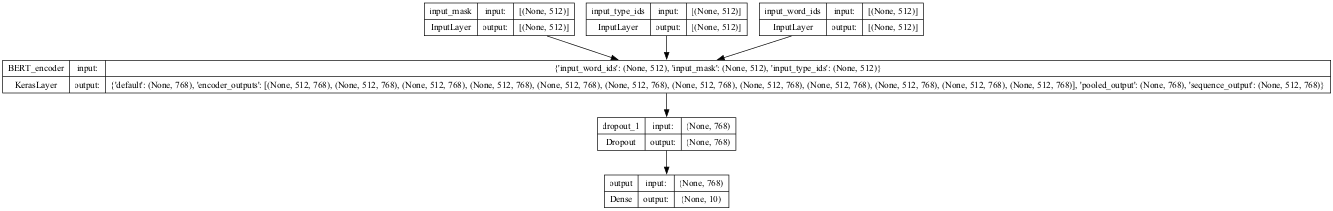

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                           

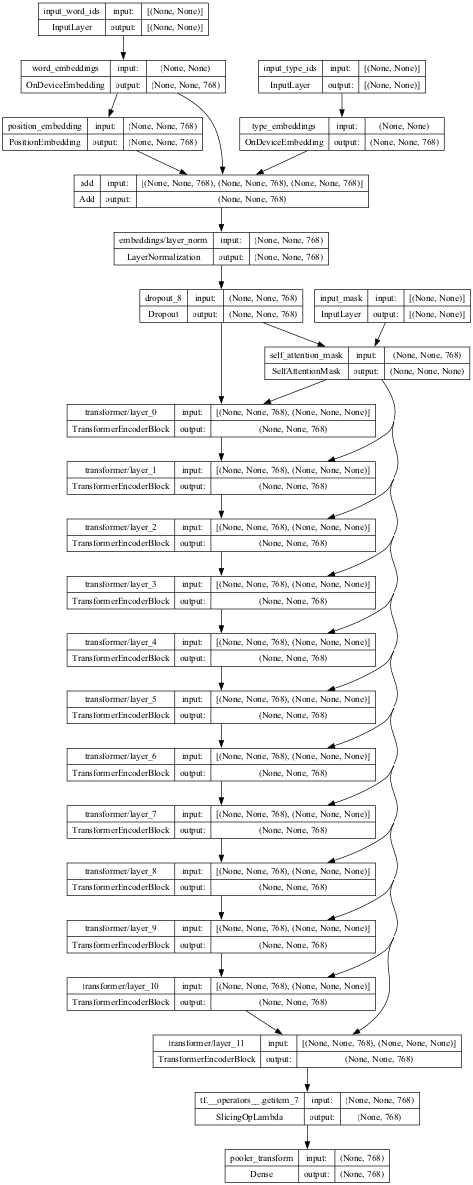

In [34]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_models as tfm

def create_detailed_bert_model(num_classes, max_length=128):
    # Define the input layers for tokenized inputs
    input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_type_ids")

    # Define the encoder configuration
    config_dict = {
        'vocab_size': 30522,
        'hidden_size': 768,
        'num_hidden_layers': 12,
        'num_attention_heads': 12,
        'intermediate_size': 3072,
        'hidden_act': 'gelu',
        'hidden_dropout_prob': 0.1,
        'attention_probs_dropout_prob': 0.1,
        'max_position_embeddings': 512,
        'type_vocab_size': 2,
        'initializer_range': 0.02,
        'layer_norm_eps': 1e-12
    }

    encoder_config = tfm.nlp.encoders.EncoderConfig({
        'type': 'bert',
        'bert': config_dict
    })

    # Build the BERT encoder
    bert_encoder = tfm.nlp.encoders.build_encoder(encoder_config)

    # Pass the inputs to the BERT layer
    bert_outputs = bert_encoder([input_word_ids, input_mask, input_type_ids])
    
    # Get the pooled output from BERT
    pooled_output = bert_outputs['pooled_output']
    
    # Add a dropout layer for regularization
    dropout = tf.keras.layers.Dropout(rate=0.1)(pooled_output)
    
    # Output layer for classification
    output = tf.keras.layers.Dense(num_classes, activation='softmax', name="classifier")(dropout)

    # Create the model
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    
    return model, bert_encoder

# Example usage
num_classes = 10  # Replace with the actual number of classes

# Create the detailed BERT model
model, bert_encoder = create_detailed_bert_model(num_classes)

# Print the model summary
model.summary()

# Plot the detailed model architecture
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)


In [11]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.sequence import pad_sequences

class BERTPreprocessor:
    '''
    The BERTPreprocessor class is designed to preprocess event log data for input into a BERT model from TensorFlow Hub. 
    It tokenizes prefix traces and maps next activities to integer class labels suitable for multi-class classification tasks.

    Attributes:
        - preprocessor: hub.KerasLayer - the preprocessor used to convert text into BERT-compatible tokens.
        - max_length: int - the maximum sequence length for tokenized inputs.
        - activity_to_label: dict - a mapping from activity names to integer class labels.
        - label_to_activity: dict - a mapping from integer class labels to activity names.
        - next_label_index: int - the next available index for new class labels.

    Methods:
        - fit_activity_labels(df): Fits activity labels from the training dataframe.
        - preprocess(df): Preprocesses the input dataframe and returns a dictionary containing BERT-compatible inputs and labels.
    '''

    def __init__(self, max_length=512):
        '''
        Initializes the BERTPreprocessor with a specified maximum sequence length.

        Input:
            - max_length (optional): int - maximum length for tokenized sequences. Default is 512.
        '''

        self.preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
        self.max_length = max_length
        self.activity_to_label = {}
        self.label_to_activity = {}
        self.next_label_index = 0

    def fit_activity_labels(self, df):
        '''
        Fits the activity labels from the provided dataframe, creating a mapping from activity names to integer class labels.

        Input:
            - df: dataframe - dataframe containing event data with a 'Next_Activity' column.
        '''
        activities = df['Next_Activity'].unique()
        self.activity_to_label = {activity: idx for idx, activity in enumerate(activities)}
        self.label_to_activity = {idx: activity for activity, idx in self.activity_to_label.items()}
        self.next_label_index = len(activities)

    def preprocess(self, df):
        '''
        Preprocesses the input dataframe by tokenizing the prefix traces and mapping next activities to integer class labels.
        Returns a dictionary containing BERT-compatible inputs and labels.

        Input:
            - df: dataframe - dataframe containing event data with 'Prefix_Trace' and 'Next_Activity' columns.

        Output:
            - A dictionary with the following keys:
                - input_word_ids: tensor - token IDs for each prefix trace.
                - input_mask: tensor - attention masks indicating real tokens and padding tokens.
                - input_type_ids: tensor - token type IDs (all zeros for single sentences).
                - labels: tensor - integer class labels for the next activities.
        '''
        # Preprocess text data
        text_inputs = df['Prefix_Trace'].tolist()
        preprocessed_text = self.preprocessor(text_inputs)
        
        # Extract the tokenized inputs
        input_word_ids = pad_sequences(preprocessed_text['input_word_ids'], maxlen=self.max_length, padding='post')
        input_mask = pad_sequences(preprocessed_text['input_mask'], maxlen=self.max_length, padding='post')
        input_type_ids = pad_sequences(preprocessed_text['input_type_ids'], maxlen=self.max_length, padding='post')

        # Map next activities to integer class labels
        labels = []
        for next_activity in df['Next_Activity']:
            if next_activity not in self.activity_to_label:
                self.activity_to_label[next_activity] = self.next_label_index
                self.label_to_activity[self.next_label_index] = next_activity
                self.next_label_index += 1
            labels.append(self.activity_to_label[next_activity])

        # Convert to tensors
        input_word_ids = tf.convert_to_tensor(input_word_ids)
        input_mask = tf.convert_to_tensor(input_mask)
        input_type_ids = tf.convert_to_tensor(input_type_ids)
        labels = tf.convert_to_tensor(labels)

        # Prepare the output dictionary
        preprocessed_text = {
            'input_mask': input_mask,
            'input_type_ids': input_type_ids,
            'input_word_ids': input_word_ids,
            'labels': labels
        }

        return preprocessed_text


# Create preprocessor
preprocessor = BERTPreprocessor(max_length=512)

# Fit activity labels
preprocessor.fit_activity_labels(train_tensor)

# Preprocess data
preprocessed_data = preprocessor.preprocess(train_tensor)

# Access the labels
labels = preprocessed_data['labels']
print(preprocessed_data)

{'input_mask': <tf.Tensor: shape=(13175, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(13175, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'input_word_ids': <tf.Tensor: shape=(13175, 512), dtype=int32, numpy=
array([[  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       ...,
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0]], dtyp